This runs on the CPU without using the IPU accelerator

The main code is taken from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html and is covered by the licence in the correspondig Githib repository, reproduced the accomanying file here, PYTORCH_EXAMPLES_LIBRARY.

In [1]:
import time
event_times = [("Start", time.time())]

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
event_times.append(("Torch imports done", time.time()))

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
event_times.append(("Data loaders created", time.time()))

Files already downloaded and verified
Files already downloaded and verified


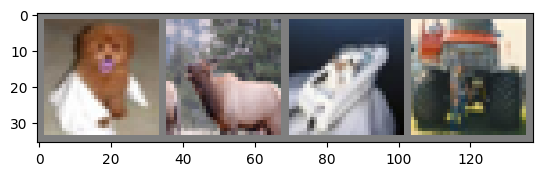

dog   deer  ship  truck


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
event_times.append(("Training batch displayed", time.time()))

In [5]:

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x  # This model has no final max - see below - loss crtierion is CrossEntropy so inlcudes a SoftMax and prediction uses max


net = Net()

event_times.append(("Base model declared", time.time()))

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
event_times.append(("Optimzer declared", time.time()))

In [7]:

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
            event_times.append((f'Epoch {epoch + 1}, Image {i + 1:5d} trained', time.time()))

print('Finished Training')
event_times.append(("Training complete", time.time()))

[1,  2000] loss: 2.191
[1,  4000] loss: 1.857
[1,  6000] loss: 1.683
[1,  8000] loss: 1.587
[1, 10000] loss: 1.523
[1, 12000] loss: 1.478
[2,  2000] loss: 1.407
[2,  4000] loss: 1.382
[2,  6000] loss: 1.337
[2,  8000] loss: 1.325
[2, 10000] loss: 1.318
[2, 12000] loss: 1.271
Finished Training


In [8]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)
event_times.append(("Model saved", time.time()))

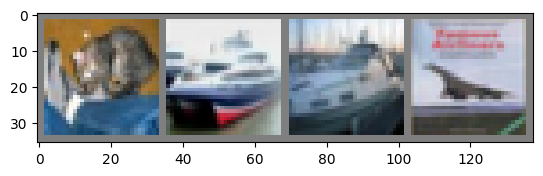

GroundTruth:  cat   ship  ship  plane


In [9]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
event_times.append(("Test batch displayed", time.time()))

In [10]:
net = Net()
net.load_state_dict(torch.load(PATH))
event_times.append(("Model loaded", time.time()))

In [11]:
outputs = net(images)
event_times.append(("Test images evaluated", time.time()))

In [12]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))
event_times.append(("Test image classes displayed", time.time()))

Predicted:  cat   ship  ship  ship 


In [13]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
event_times.append(("Test image class accuracy", time.time()))

Accuracy of the network on the 10000 test images: 54 %


In [14]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

event_times.append(("Test image accuracy by class", time.time()))

Accuracy for class: plane is 50.9 %
Accuracy for class: car   is 66.6 %
Accuracy for class: bird  is 47.2 %
Accuracy for class: cat   is 45.4 %
Accuracy for class: deer  is 38.1 %
Accuracy for class: dog   is 41.2 %
Accuracy for class: frog  is 74.0 %
Accuracy for class: horse is 56.6 %
Accuracy for class: ship  is 79.0 %
Accuracy for class: truck is 44.2 %


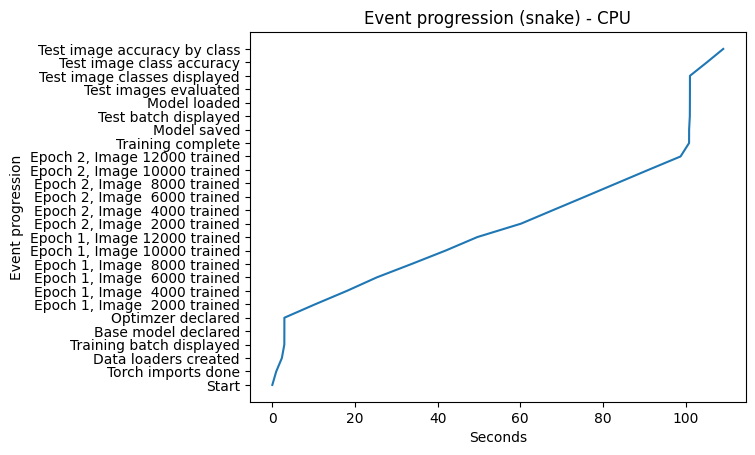

In [15]:
import json
event_times = [(label, event_time - event_times[0][1]) for label, event_time in event_times]
with open("times_cpu.json", "w") as f:
    json.dump(event_times, f)

import matplotlib.pyplot as plt
labels, times = list(zip(*event_times))
x = times
y = list(range(len(labels)))

plt.plot(x, y)
plt.title("Event progression (snake) - CPU")
plt.xlabel('Seconds')
plt.ylabel('Event progression')
plt.yticks(ticks=y, labels=labels)
plt.show()
